### USING NLP PROCESSING, UNDERSTANDING THE SENTIMENT OF A TWEET, AND THEN COMPARING IT WITH THE ACTUAL RESULTS
### This helps to understand how twitter data can be used massively for predicting outcomes which has innumerable variables- Apoorv Brief

In [ ]:
# Imports
import numpy as np
import pandas as pd
import re

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May  1 13:57:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install pyspark

     |████████████████████████████████| 281.4 MB 38 kB/s 
     |████████████████████████████████| 198 kB 61.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=5f523f01486a58ef12afaa244f4076d4c6a5d9ccb0b4098fc1db61048a9af56b
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
#!pip install pyspark
# Spark Imports
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, RegexTokenizer, CountVectorizer, \
           StopWordsRemover, NGram, HashingTF, IDF, Word2Vec

from pyspark.sql.functions import explode, expr
from pyspark.ml.functions  import vector_to_array

from pyspark.sql.functions import length, size

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LogisticRegressionModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [ ]:
# Visualization imports
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import os
import plotly.express as pxw
import plotly.graph_objs as go
import collections
from collections import defaultdict


### Spark Initializer

In [ ]:
# Initializing Spark
spark = SparkSession.builder.appName("FinalML").getOrCreate()
sc = spark.sparkContext

### Data Loading

In [ ]:
from pyspark.sql.functions import lit

Joe Biden Data

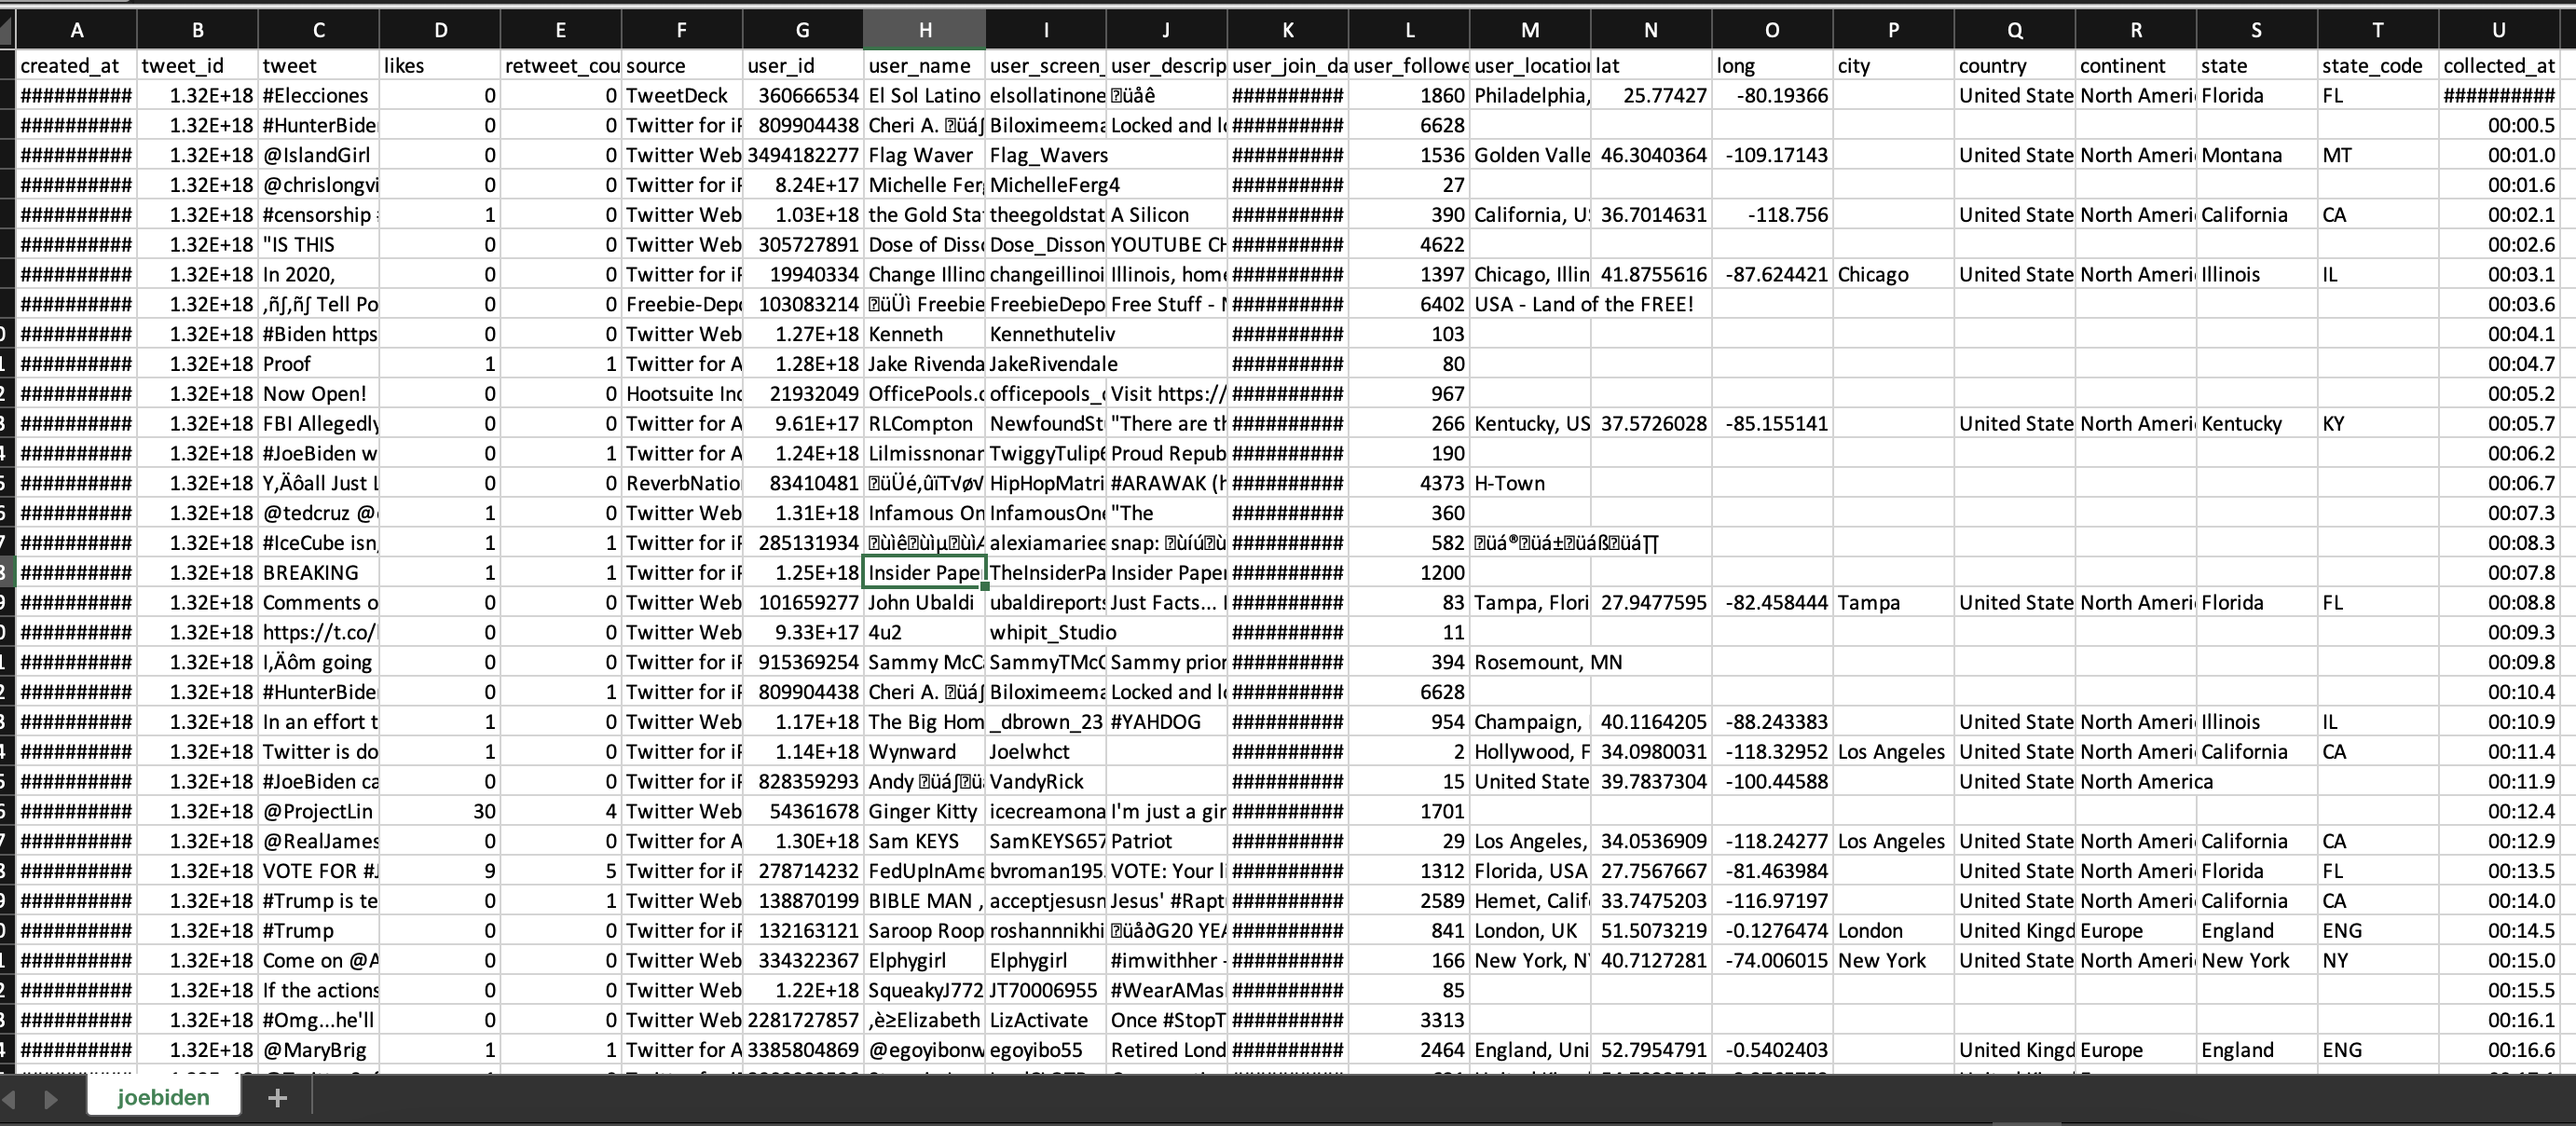

In [ ]:
# Loading Biden data with Spark
biden_df = spark.read.csv('joebiden.csv', inferSchema=True, header=True, sep=',')
biden_df = biden_df.dropna()
biden_df = biden_df.withColumn('candidate', lit('Joe Biden'))

Donald Trump Data

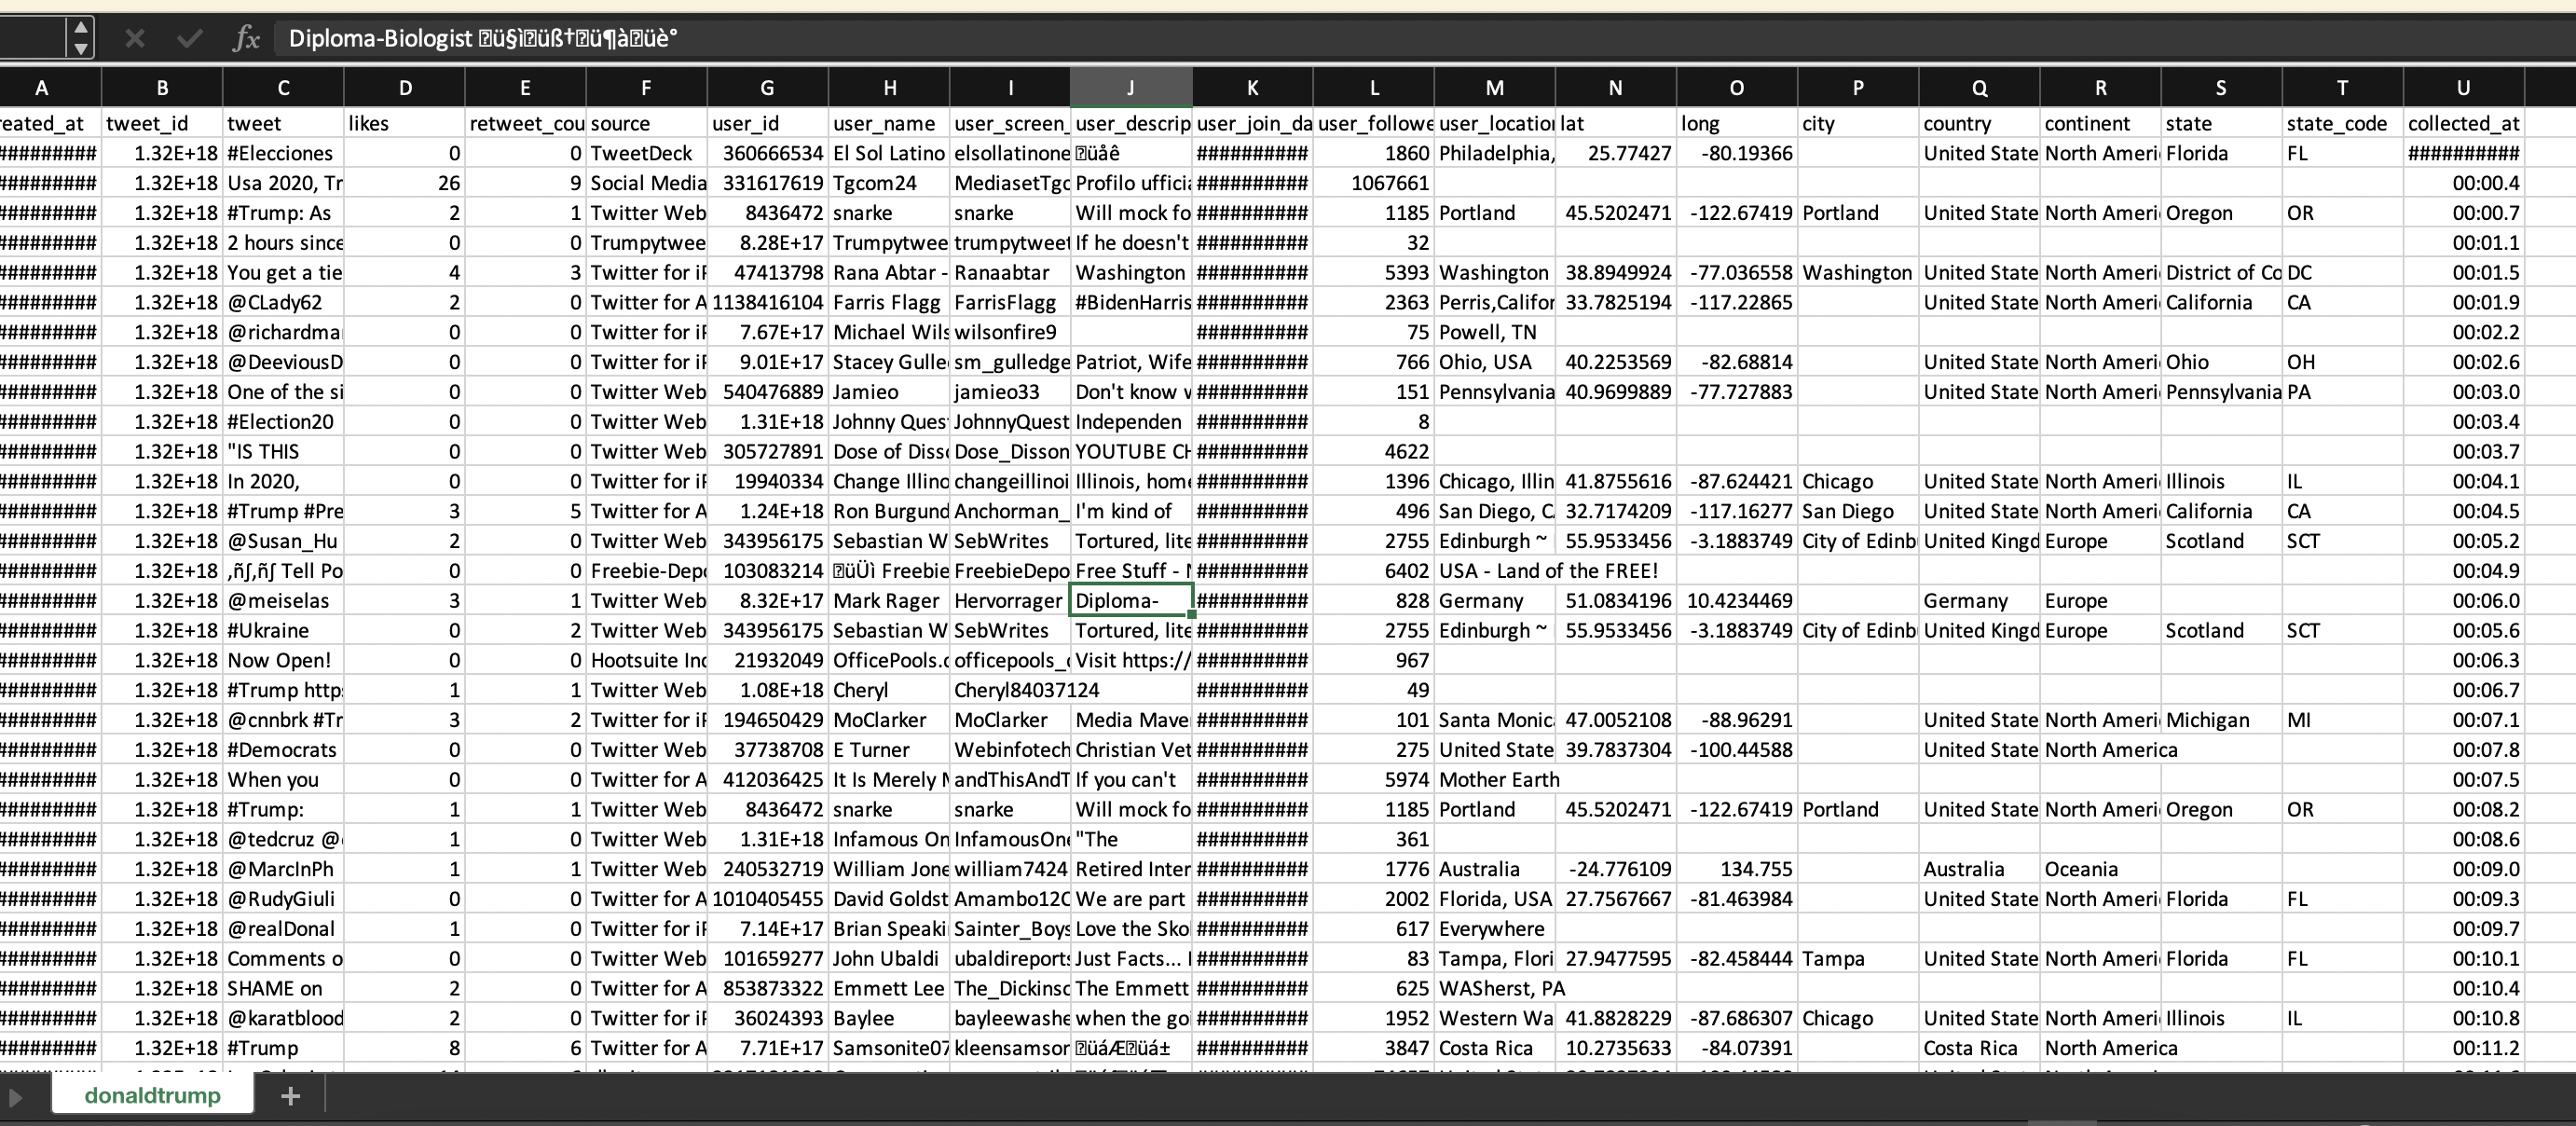

In [ ]:
# Loading Trump data with Spark
trump_df = spark.read.csv('donaldtrump.csv', inferSchema=True, header=True, sep=',')
trump_df = trump_df.dropna()
trump_df = trump_df.withColumn('candidate', lit('Donald Trump'))

In [ ]:
# Merging Dataframes
elections_df = biden_df.union(trump_df)

In [ ]:
elections_df.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- retweet_count: string (nullable = true)
 |-- source: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_join_date: string (nullable = true)
 |-- user_followers_count: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- collected_at: string (nullable = true)
 |-- candidate: string (nullable = false)



### Twitter Data Filtering / Formatting - Janvi start

In [ ]:
from pyspark.sql.functions import *

In [ ]:
import datetime
# Selecting Relevant Colums
elections_filtered_df = elections_df.select(elections_df.created_at.alias('date'),'tweet','country','state','state_code','Candidate')
# Filtering US Tweets
elections_filtered_df = elections_filtered_df.filter(elections_filtered_df.country == 'United States of America')
# Giving Format to dates
elections_filtered_df = elections_filtered_df.withColumn('date',elections_filtered_df.date[0:10])
elections_filtered_df = elections_filtered_df.withColumn('date',to_date(col("date"),"yyyy-MM-dd"))
# Filtering Tweets 'October 16th 2020' - 'Day of Elections'
elections_filtered_df = elections_filtered_df.filter((elections_filtered_df.date < datetime.date(2020,11,3)) & (elections_filtered_df.date > datetime.date(2020,10,15)))

In [ ]:
# Number of data
elections_filtered_df.count()

43386

Are the data balanced for each candidate?

In [ ]:
# Number of Data per Candidate
elections_filtered_df.groupBy('candidate').count().show()

+------------+-----+
|   candidate|count|
+------------+-----+
|   Joe Biden|19178|
|Donald Trump|24208|
+------------+-----+



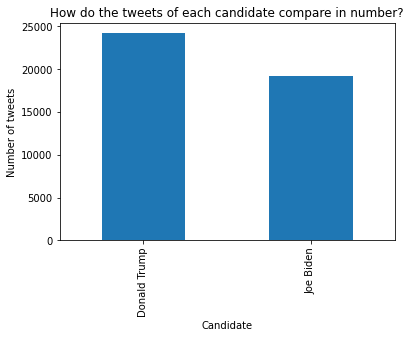

In [ ]:
# Converting data into Pandas for Plotting
election_pandas = elections_filtered_df.toPandas()

election_pandas.groupby('Candidate')['tweet'].count().plot.bar()
plt.xlabel("Candidate")
plt.ylabel('Number of tweets')
plt.title('How do the tweets of each candidate compare in number?')
plt.show()

How many tweets do we have per State?

In [ ]:
# Number of Data per State
elections_filtered_df.groupBy('state').count().orderBy('state').show(50)

+--------------------+-----+
|               state|count|
+--------------------+-----+
|             Alabama|  158|
|              Alaska|   69|
|             Arizona|  820|
|            Arkansas|   43|
|          California| 8716|
|            Colorado|  773|
|         Connecticut|   58|
|            Delaware|    7|
|District of Columbia| 3355|
|             Florida| 3106|
|             Georgia| 1084|
|              Hawaii|  153|
|               Idaho|  108|
|            Illinois| 1913|
|             Indiana|  279|
|                Iowa|   66|
|              Kansas|   67|
|            Kentucky|  151|
|           Louisiana|  252|
|               Maine|   14|
|            Maryland|  329|
|       Massachusetts| 1017|
|            Michigan|  563|
|           Minnesota|  395|
|         Mississippi|   53|
|            Missouri|  474|
|             Montana|   22|
|            Nebraska|   72|
|              Nevada|  779|
|       New Hampshire|   27|
|          New Jersey|  232|
|          New

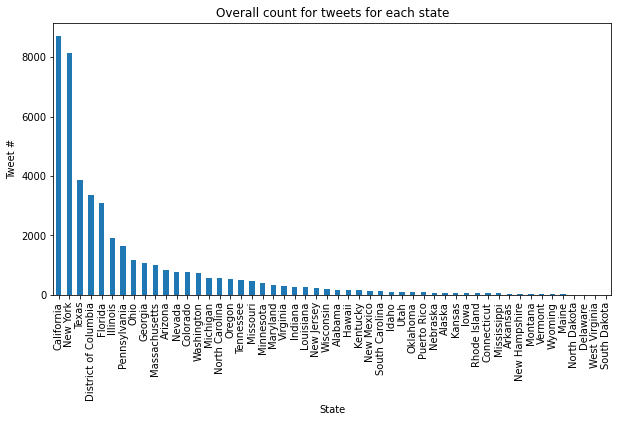

In [ ]:
plt.figure(figsize=(10,5))
election_pandas.groupby('state')['tweet'].count().sort_values(ascending=False).plot.bar()
plt.xlabel('State')
plt.ylabel('Tweet #')
plt.title('Overall count for tweets for each state')
plt.show()

How many tweets do we have per State and Candidate?

In [ ]:
# Number of Data per State & Candidate
elections_filtered_df.groupBy('state','candidate').count().orderBy('state','candidate').show()

+--------------------+------------+-----+
|               state|   candidate|count|
+--------------------+------------+-----+
|             Alabama|Donald Trump|   61|
|             Alabama|   Joe Biden|   97|
|              Alaska|Donald Trump|   27|
|              Alaska|   Joe Biden|   42|
|             Arizona|Donald Trump|  412|
|             Arizona|   Joe Biden|  408|
|            Arkansas|Donald Trump|   25|
|            Arkansas|   Joe Biden|   18|
|          California|Donald Trump| 5204|
|          California|   Joe Biden| 3512|
|            Colorado|Donald Trump|  467|
|            Colorado|   Joe Biden|  306|
|         Connecticut|Donald Trump|   28|
|         Connecticut|   Joe Biden|   30|
|            Delaware|Donald Trump|    4|
|            Delaware|   Joe Biden|    3|
|District of Columbia|Donald Trump| 2141|
|District of Columbia|   Joe Biden| 1214|
|             Florida|Donald Trump| 1774|
|             Florida|   Joe Biden| 1332|
+--------------------+------------

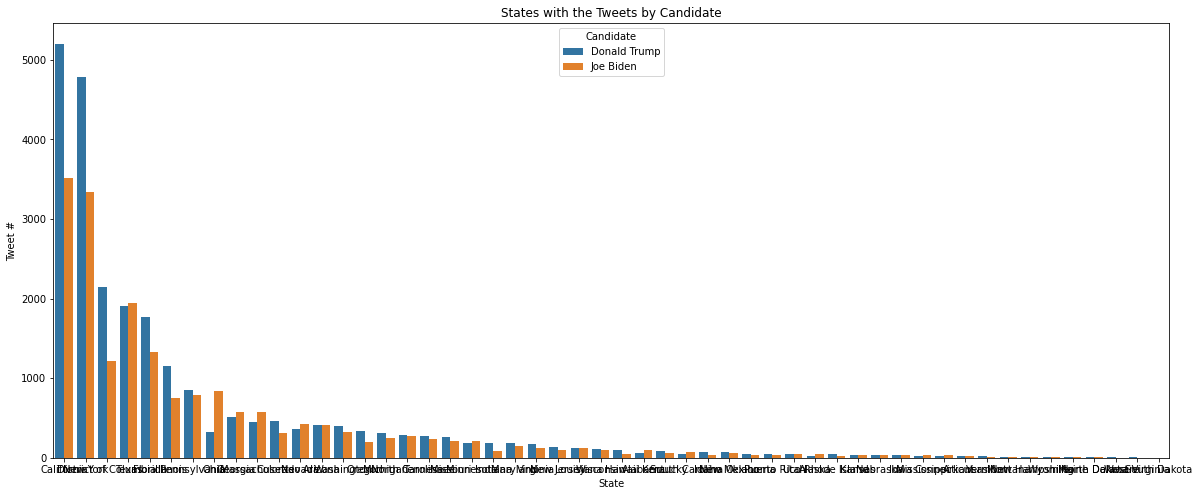

In [ ]:
top_states = election_pandas.groupby('state')['tweet'].count().sort_values(ascending=False).index.tolist()

country_df = election_pandas.groupby(['state','Candidate'])['tweet'].count().reset_index()
plt.figure(figsize=(20,8))
country_df = country_df.sort_values(by='tweet', ascending=False)
country_df = country_df[country_df['state'].isin(top_states)]
sns.barplot(data=country_df,x='state',y='tweet',hue='Candidate')
plt.xlabel('State')
plt.ylabel('Tweet #')
plt.title('States with the Tweets by Candidate')
plt.show()

In [ ]:
from pyspark.sql import functions as F

# Cleaning-Up Tweet
# =================
# Lowercasing all the tweets
elections_filtered_df = elections_filtered_df.withColumn('tweet', lower(col('tweet')))
# Removing Links
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', r'http\S+', ''))
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', r'www.\S+', ''))
# Removing hashtags and mentions
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', '#', ''))
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', '@', ''))
# Removing RTs
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', 'RT', ''))
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', ':', ''))
# Removing punctuactions
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', '[()!?]', ''))
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', '\[.*?\]', ''))
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', '"', ''))
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', ',', ''))
# Removing non-alphanumeric characters
#elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', '[^a-zA-Z0-9 -]', '  '))

What are the most frequent key words?

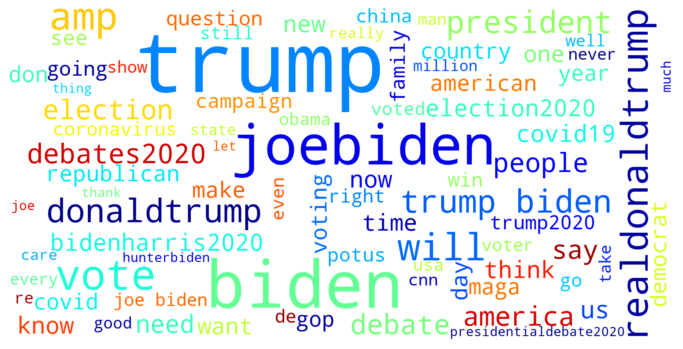

In [ ]:
# Converting data into Pandas for Plotting
election_pandas = elections_filtered_df.toPandas()

# Word Cloud
def word_cloud(wd_list):
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear")

word_cloud(election_pandas['tweet'].sample(2000))

Which candidate has had more social media representation?

In [ ]:
def get_day(timestamp):
    day = timestamp
    return day

time_df = election_pandas.dropna(subset=['tweet'])
time_df['date'] = time_df['date'].apply(get_day)
time_df = time_df.groupby(['Candidate', 'date'])['tweet'].count().reset_index()

fig = pxw.line(time_df, x='date', y='tweet', color='Candidate', 
    labels={
                     "date": "Date",
                     "tweet": "Tweet #",
    },
    title="Daily Number of Tweets per Candidate")

fig.show()

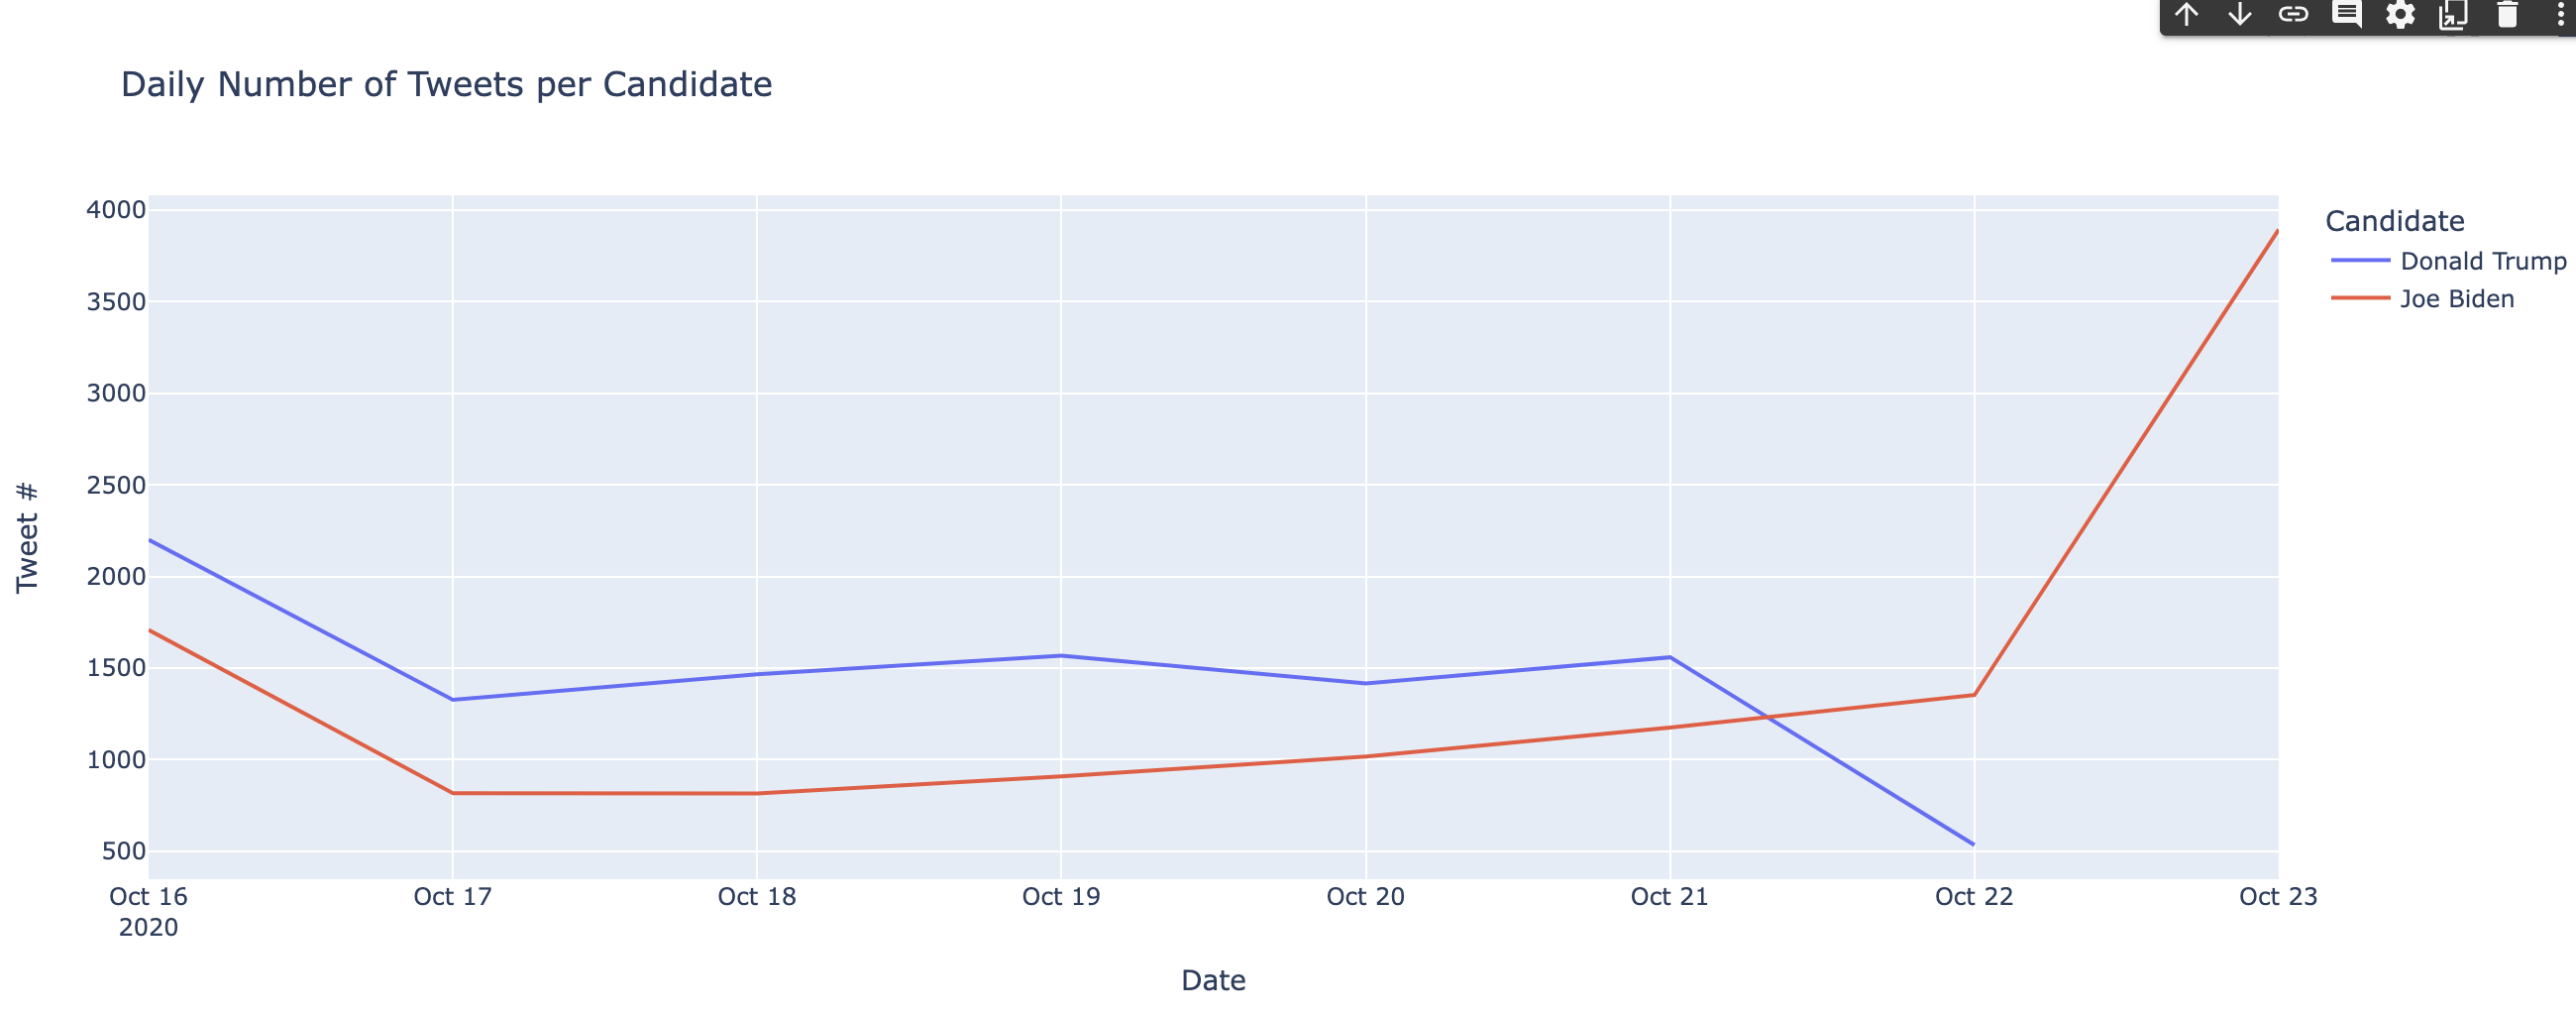

In [ ]:
state_df = election_pandas[election_pandas['country'] == 'United States of America'].dropna(subset=['state_code']).groupby(['state_code','Candidate'])['tweet'].count().reset_index()
state_df = state_df.set_index(['Candidate', 'state_code']).unstack(level=0)

def getDiff(state):
    total = state[1] + state[0]
    diff = state[1] - state[0]  # trump - biden
    
    return diff/total

state_df = state_df.apply(getDiff, axis=1).reset_index().rename({0: 'diff'}, axis=1)

In [ ]:
fig = px.choropleth(state_df,
                    locations='state_code',
                    locationmode="USA-states",
                    scope='usa',
                    color='diff',
                    color_continuous_scale=('#4040ff', '#ff4040'),
                    range_color=(0, 0.2),
                    color_continuous_midpoint=0,
                    )
fig.show()

In [ ]:
election_pandas

date                                              tweet  \
0      2020-10-16  trump exige a biden que revele de inmediato el...   
1      2020-10-16  lock in abc joebiden gstephanopoulos ready 👏🏾👏...   
2      2020-10-16                let’s go joe. nbcblackout joebiden    
3      2020-10-16  now watching abc  not because i like them but ...   
4      2020-10-16  i really feel sorry for joebiden he’s being us...   
...           ...                                                ...   
43381  2020-10-29  voteinperson toobigtorig trump voteredtosaveam...   
43382  2020-10-29  the lies now spit out of nearly every sentence...   
43383  2020-10-29                       wait for it... trump bible     
43384  2020-10-29  trump boo hoo vote  sen. martha mcsally out   ...   
43385  2020-10-29  gotselfworth daughters a wife you admire a mot...   

                        country         state state_code     Candidate  
0      United States of America       Florida         FL     Joe Biden  
1      United States of America      New York         NY     Joe Biden  
2      United States of America     Tennessee         TN     Joe Biden  
3      United States of America      Michigan         MI     Joe Biden  
4      United States of America    California         CA     Joe Biden  
...                         ...           ...        ...           ...  
43381  United States of America    California         CA  Donald Trump  
43382  United States of America      New York         NY  Donald Trump  
43383  United States of America      New York         NY  Donald Trump  
43384  United States of America      New York         NY  Donald Trump  
43385  United States of America  Pennsylvania         PA  Donald Trump  

[43386 rows x 6 columns]

In [ ]:
state_time_df = election_pandas[election_pandas['country'] == 'United States of America'].dropna(subset=['state_code'])
state_time_df['date_str'] = election_pandas['date'].apply(lambda x: str(x))
state_time_df = state_time_df.groupby(['state_code', 'Candidate', 'date_str'])['tweet'].count().reset_index()

state_time_df.head()

state_code     Candidate    date_str  tweet
0         AK  Donald Trump  2020-10-18      1
1         AK  Donald Trump  2020-10-19      1
2         AK  Donald Trump  2020-10-20      2
3         AK  Donald Trump  2020-10-21      4
4         AK  Donald Trump  2020-10-23     10

In [ ]:
fig = px.choropleth(state_time_df,
                    locations='state_code',
                    locationmode='USA-states',
                    animation_frame='date_str',
                    scope='usa',
                    color='tweet',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=(0, 1000),
                    width=1000,
                    height=500
                    )
fig.show()

In [ ]:
time_df = election_pandas.dropna(subset=['tweet'])
time_df = time_df.groupby(['Candidate', 'date'])['tweet'].count().reset_index()

fig = px.line(time_df, x='date', y='tweet', color='Candidate')

fig.show()

### Splitting data

We are going to use 30% of the data for training/testing the model and the other 70% for making predictions.

In [ ]:
# Splitting data
model_df, predicting_df = elections_filtered_df.randomSplit([0.3, 0.7], seed=1)

# Seeing if data from both candidates is balanced
model_df.groupBy('candidate').count().show()
predicting_df.groupBy('candidate').count().show()

+------------+-----+
|   candidate|count|
+------------+-----+
|   Joe Biden| 5810|
|Donald Trump| 7187|
+------------+-----+

+------------+-----+
|   candidate|count|
+------------+-----+
|   Joe Biden|13368|
|Donald Trump|17021|
+------------+-----+



### Sentiment Labeling with TextBlob - Suri

In [ ]:
# Importing TextBlob
from textblob import TextBlob

In [ ]:
# Getting the Polarity
    # 1: Positive
    # 0: Negative

def getSentiment(tweet):
    polarity = TextBlob(tweet).sentiment.polarity
    if(polarity > 0):
        return positive
    elif (polarity < 0):
        return negative
    else:
        return neutral

def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

In [ ]:
election_pandas['sentiment'] = election_pandas['tweet'].apply(lambda x: getSentiment(x))
election_pandas['polarity'] = election_pandas['tweet'].apply(lambda x: getSentiment(x))

In [ ]:
election_pandas['sentiment']=election_pandas['sentiment'].replace(0,'negative')
election_pandas['sentiment']=election_pandas['sentiment'].replace(1,'positive')
election_pandas['sentiment']=election_pandas['sentiment'].replace(2,'neutral')

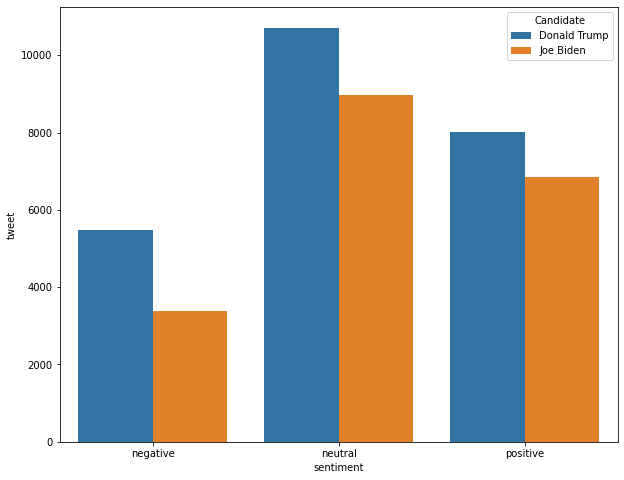

In [ ]:
sentiment_count_df = election_pandas.groupby(['sentiment', 'Candidate'])['tweet'].count().reset_index()
plt.figure(figsize=(10,8))
sns.barplot(data=sentiment_count_df, x='sentiment', y='tweet', hue='Candidate')
plt.show()

In [ ]:
polarity = udf(lambda x: getPolarity(x))
sentiment = udf(lambda x: getSentiment(x))

spark.udf.register("polarity", polarity)
spark.udf.register("sentiment", sentiment)

model_df2 = model_df.withColumn('polarity',polarity('tweet').cast('double')) \
                    .withColumn('sentiment',sentiment('tweet').cast('double')).dropna()

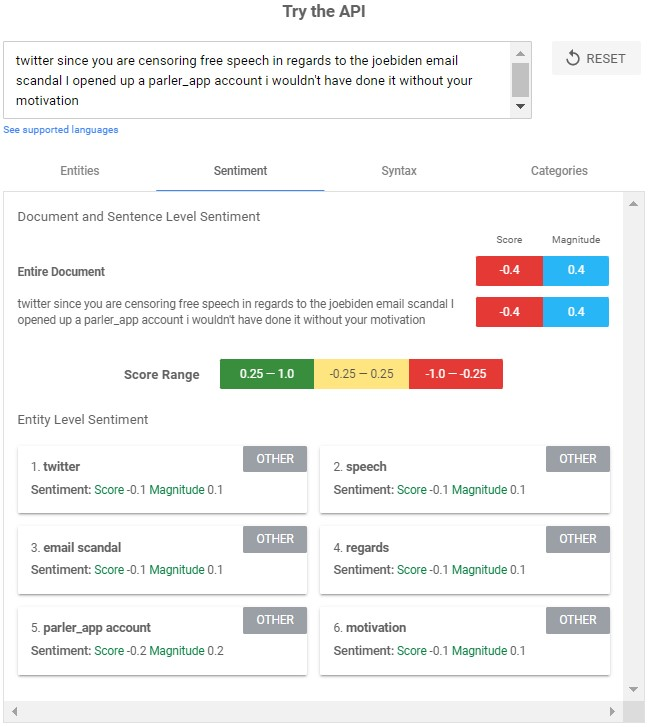

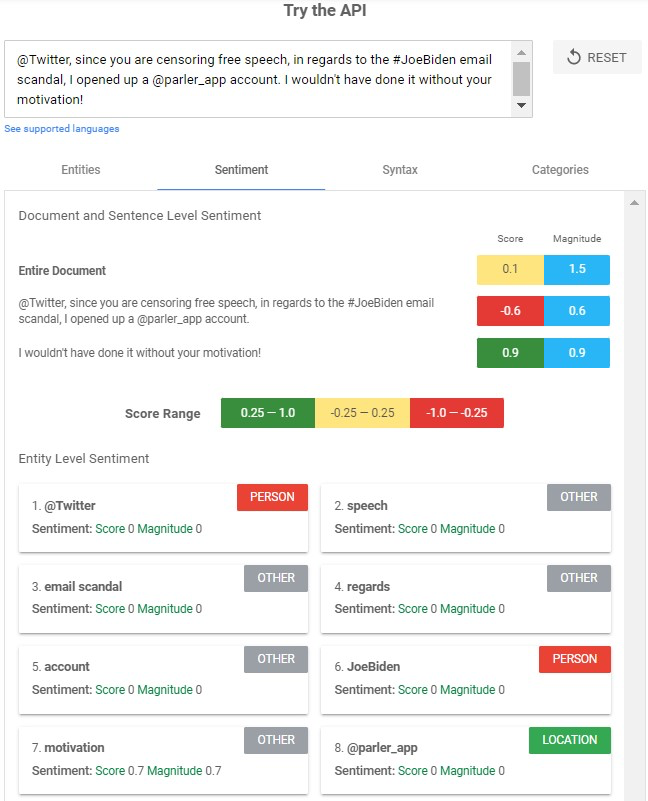

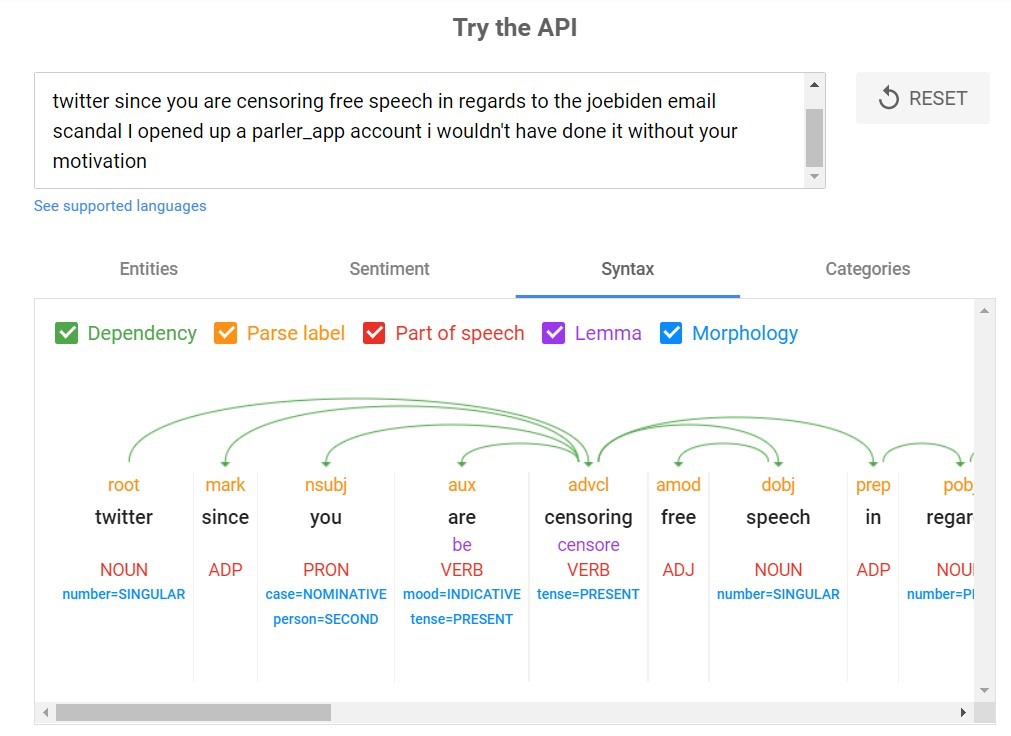

### DEFINING GOOGLE CLOUD NATURAL PROCESSING LANGUAGE API

In [ ]:
#!pip install google-cloud-language
from google.cloud import language_v1
from pyspark.sql.types import *

# Instantiates a client
client = language_v1.LanguageServiceClient.from_service_account_json('cs777-service_account_api_key.json')

# Create empty dataframe to store GCP_sentiment scores
emp_RDD = spark.sparkContext.emptyRDD()
GCP_col = StructType([StructField('GCP_sentiment_label', IntegerType(), False), 
                     StructField('GCP_sentiment_score', FloatType(), False)])
GCP_df = spark.createDataFrame(data=emp_RDD, schema=GCP_col)

def getTweetInfo(current_tweet):
    doc = language_v1.types.Document(content = current_tweet, type = 1)
    gcp_sentiment = client.analyze_sentiment(document=doc).document_sentiment.score
    if(gcp_sentiment > 0.1):
        gcp_polarity = 1
    elif (gcp_sentiment < -0.1):
        gcp_polarity = 0
    else:
        gcp_polarity = 2
    # print(current_tweet)
    return [gcp_polarity, gcp_sentiment]

    
# NLP API call
senti_scores = []
for i in range(5):
  current_tweet = model_df.select('tweet').collect()[i][0]
  senti_values = getTweetInfo(current_tweet)
  newRow = spark.createDataFrame([senti_values], ['GCP_sentiment_label', 'GCP_sentiment_score'])
  GCP_df = GCP_df.union(newRow)

GCP_df = GCP_df.withColumn("GCP_sentiment_score", F.round(GCP_df["GCP_sentiment_score"], 3))

# Merge GCP sentiment data with original dataset
from pyspark.sql import *
w_gcp = Window.orderBy(lit(1))

dataset = model_df.withColumn("row_num",row_number().over(w_gcp)-1)
GCP_df = GCP_df.withColumn("row_num",row_number().over(w_gcp)-1)
dataset_new = dataset.join(GCP_df,["row_num"]).drop("rn").show()

FileNotFoundError: ignored

In [ ]:
model_df.count()

6557

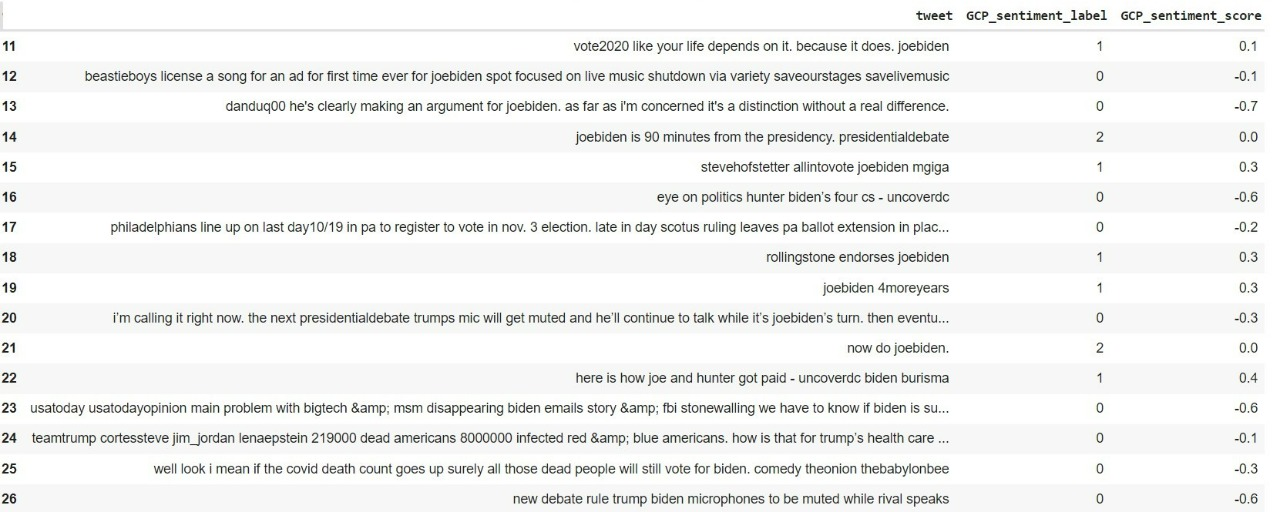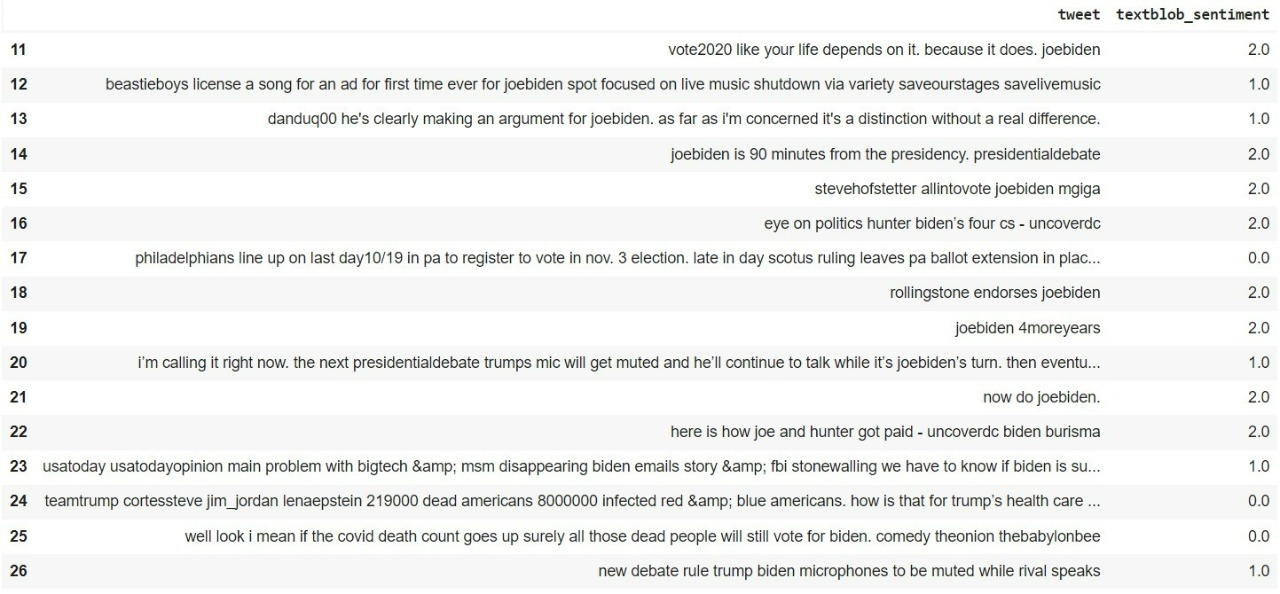

### Data Preprocessing

In [ ]:
# Filter NEUTRAL Sentiments
model_df2 = model_df2.filter(model_df2.sentiment != 2).withColumn('sentiment', col('sentiment').cast('double'))
model_df2.groupBy('sentiment').count().orderBy('sentiment').show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      0.0| 2725|
|      1.0| 4406|
+---------+-----+



In [ ]:
# Regex Tokenizer
tokenizer = RegexTokenizer(inputCol="tweet", 
                           outputCol="raw_tokens",
                           pattern= "\\W")
rawTokenizedDF = tokenizer.transform(model_df2)

# StopWords Remover
remover = StopWordsRemover(inputCol='raw_tokens',
                           outputCol='clean_tokens')
cleanTokenizedDF = remover.transform(rawTokenizedDF)
cleanTokenizedDF = cleanTokenizedDF.withColumn('num_tokens', size(cleanTokenizedDF['clean_tokens']))

# Count Vectorizer
countVectorizer = CountVectorizer(inputCol='clean_tokens',
                                  outputCol='raw_features')
cv_model = countVectorizer.fit(cleanTokenizedDF)
cv_df = cv_model.transform(cleanTokenizedDF)

# rescaling data
idf = IDF(inputCol="raw_features", outputCol="idf_features")
idfModel = idf.fit(cv_df)
rescaledData = idfModel.transform(cv_df)

### VISUALIZATION OF AREA UNDER THE CURVE

In [ ]:
def areaUnderROC(myModel):
    trainingSummary = myModel.summary
    roc = trainingSummary.roc.toPandas()
    plt.plot(roc['FPR'],roc['TPR'])
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))
    return trainingSummary

### Classifications Models - Apoorv start end

#### Logistic Regression

In [ ]:
# Logistic Regression
#====================

# Vector Assembler
vecAssembler = VectorAssembler(inputCols=['idf_features', 'num_tokens'], 
outputCol='features')
dataset = vecAssembler.transform(rescaledData)

# Splitting data into training/test sets
training_df, test_df = dataset.randomSplit([0.80,0.20], seed=1)

#Building the model
log_reg = LogisticRegression(featuresCol='features', labelCol='sentiment')

# Training the model
lr_model = log_reg.fit(training_df)

# Testing the model
lr_result = lr_model.transform(test_df)
lr_result.groupBy('prediction').pivot('sentiment').count().show()

+----------+---+---+
|prediction|0.0|1.0|
+----------+---+---+
|       0.0|397|136|
|       1.0|183|754|
+----------+---+---+



In [ ]:
# Multi-Class Evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment", predictionCol="prediction",
    metricName="accuracy")

In [ ]:
# Create Parameter-Grid for Cross Validation
lrparamGrid = ParamGridBuilder() \
    .addGrid(log_reg.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(log_reg.elasticNetParam, [0.5, 0.7, 0.9]) \
    .addGrid(log_reg.maxIter, [1, 5, 10])\
    .build()

# 10-Fold Cross Validator
lrcv = CrossValidator(estimator = log_reg,
                    estimatorParamMaps = lrparamGrid,
                    evaluator = evaluator,
                    numFolds = 10)

In [ ]:
# Fitting Cross-Validation to get the Best Model
lcrvModel = lrcv.fit(training_df)
lr_bestModel = lcrvModel.bestModel

print(lr_bestModel.getRegParam())
print(lr_bestModel.getElasticNetParam())
print(lr_bestModel.getMaxIter())

In [ ]:
# Evaluating the accuracy of the model with the test set
# Predictions with the test set
predictions =lr_bestModel.transform(test_df)

# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment", predictionCol="prediction",
    metricName="accuracy")

accuracy_lr = evaluator.evaluate(predictions)
print ("Model Accuracy: ", accuracy_lr)

22/04/28 18:28:52 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:28:57 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:29:01 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


Model Accuracy:  0.8532494758909853


In [ ]:
# Area Under the curve (AUC)
# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment", predictionCol="prediction")

auc_lc = evaluator.evaluate(predictions)
print ("AUC: ", auc_lc)

22/04/28 18:29:17 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:29:30 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:29:33 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:29:42 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:29:42 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:29:42 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:29:42 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:29:43 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:29:43 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:29:43 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:29:43 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:29:44 WARN DAGScheduler: Broadcasting larg

AUC:  0.8474754183951935


In [ ]:
def printConfusionMatrix(predictions):
    # Confussion Matrix
  true_positives = predictions[(predictions.sentiment == 1) & 
      (predictions.prediction == 1)].count()

  true_negatives = predictions[
      (predictions.sentiment == 0) & 
      (predictions.prediction == 0)].count()

  false_positives = predictions[
      (predictions.sentiment == 0) & 
      (predictions.prediction == 1)].count()

  false_negatives = predictions[
      (predictions.sentiment == 1) & 
      (predictions.prediction == 0)].count()

  print ("TN =", true_negatives, "  ", "FP =", false_positives)
  print ("FP =", false_negatives, "   ", "TP =", true_positives)

In [ ]:
¡¡¡¡¡¡¡¡¡¡¡¡type(log_reg)

pyspark.ml.classification.LogisticRegression

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



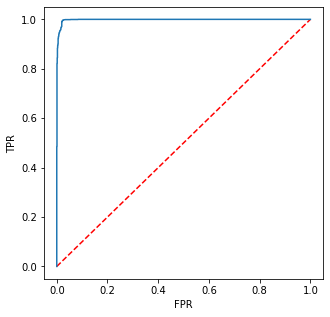

In [ ]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lr_bestModel.summary.roc.select('FPR').collect(),
         lr_bestModel.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Naive Bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes

In [ ]:
# Naive Bayes
#====================

#Building the model
naive_bayes = NaiveBayes(featuresCol='features', labelCol='sentiment')

# Training the model
naive_bayes_model = naive_bayes.fit(training_df)

# Testing the model
nb_result = naive_bayes_model.transform(test_df)
nb_result.groupBy('prediction').pivot('sentiment').count().show()

+----------+---+---+
|prediction|0.0|1.0|
+----------+---+---+
|       0.0|207|155|
|       1.0| 77|314|
+----------+---+---+



In [ ]:
# Multi-Class Evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment", predictionCol="prediction",
    metricName="accuracy")

In [ ]:
# Create Parameter-Grid for Cross Validation
nbparamGrid = ParamGridBuilder() \
    .addGrid(naive_bayes.smoothing, [0.0, 0.1, 10.0, 100.0]) \
    .build()

# 10-Fold Cross Validator
nbcv = CrossValidator(estimator = naive_bayes,
                    estimatorParamMaps = nbparamGrid,
                    evaluator = evaluator,
                    numFolds = 10)

In [ ]:
# Fitting Cross-Validation to get the Best Model
nbrvModel = nbcv.fit(training_df)
nb_bestModel = nbrvModel.bestModel


In [ ]:
print(nb_bestModel.getSmoothing())

10.0


In [ ]:
# Evaluating the accuracy of the model with the test set
# Predictions with the test set
predictions = nb_bestModel.transform(test_df)

# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment", predictionCol="prediction",
    metricName="accuracy")

accuracy_nb = evaluator.evaluate(predictions)
print ("Model Accuracy: ", accuracy_nb)

Model Accuracy:  0.749003984063745


In [ ]:
# Area Under the curve (AUC)
# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment", predictionCol="prediction")

auc_nb = evaluator.evaluate(predictions)
print ("AUC: ", auc_nb)

AUC:  0.7447614121010044


In [ ]:
printConfusionMatrix(predictions)

TN = 170    FP = 114
FP = 75     TP = 394


#### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
# Random Forest
#====================

#Building the model
random_forest = RandomForestClassifier(featuresCol='features', labelCol='sentiment')

# Training the model
random_forest_model = random_forest.fit(training_df)

# Testing the model
nb_result = random_forest_model.transform(test_df)
nb_result.groupBy('prediction').pivot('sentiment').count().show()

In [ ]:
# Multi-Class Evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment", predictionCol="prediction",
    metricName="accuracy")

In [ ]:
# Create Parameter-Grid for Cross Validation
rfparamGrid = ParamGridBuilder() \
    .addGrid(random_forest.numTrees, [10, 50, 100, 200, 300, 400, 500]) \
    .build()

# 10-Fold Cross Validator
rfcv = CrossValidator(estimator = random_forest,
                    estimatorParamMaps = rfparamGrid,
                    evaluator = evaluator,
                    numFolds = 10)

In [ ]:
# Fitting Cross-Validation to get the Best Model
rfrvModel = rfcv.fit(training_df)
rf_bestModel = rfrvModel.bestModel

In [ ]:
print(rf_bestModel.getNumTrees)

10


In [ ]:
# Evaluating the accuracy of the model with the test set
# Predictions with the test set
predictions = rf_bestModel.transform(test_df)

# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment", predictionCol="prediction",
    metricName="accuracy")

accuracy_rf = evaluator.evaluate(predictions)
print ("Model Accuracy: ", accuracy_rf)

22/04/28 18:12:04 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


Model Accuracy:  0.6278825995807128


In [ ]:
# Area Under the curve (AUC)
# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment", predictionCol="prediction")

auc_rf = evaluator.evaluate(predictions)
print ("AUC: ", auc_rf)

22/04/28 18:12:26 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


AUC:  0.48435502530437474


In [ ]:
printConfusionMatrix(predictions)

22/04/28 18:13:31 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:13:49 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:14:05 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:14:23 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


TN = 0    FP = 710
FP = 0     TP = 1198


### Gradien Boost Algorithm

In [ ]:
from pyspark.ml.classification import GBTClassifier
# GBT Classifier
#====================

#Building the model
gbt_classifier = GBTClassifier(featuresCol='features', labelCol='sentiment')

# Training the model
gbt_model = gbt_classifier.fit(training_df)

# Testing the model
gbt_result = gbt_model.transform(test_df)
gbt_result.groupBy('prediction').pivot('sentiment').count().show()
accuracy_gbt = evaluator.evaluate(gbt_result)
print ("Model AccuracyGBT without K-fold: ", accuracy_gbt)

In [ ]:
# Multi-Class Evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment", predictionCol="prediction",
    metricName="accuracy")

In [ ]:
# Takes 1 hour to run

paramGrid = (ParamGridBuilder()
             .addGrid(gbt_classifier.maxDepth, [2, 4, 6])
             .addGrid(gbt_classifier.maxBins, [20, 60])
             .addGrid(gbt_classifier.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt_classifier, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(training_df)
predictions = cvModel.transform(test_df)
accuracy_gbt = evaluator.evaluate(predictions)
print ("Model Accuracy: ", accuracy_gbt)

### FM Classifier

In [ ]:
from pyspark.ml.classification import FMClassifier

fm = FMClassifier(labelCol='sentiment', \
              featuresCol="features", \
              stepSize=0.001)

# Training the model
fm_model = fm.fit(training_df)

# Testing the model
fm_result = fm_model.transform(test_df)
fm_result.groupBy('prediction').pivot('sentiment').count().show()
accuracy_fm = evaluator.evaluate(fm_result)
print ("Model AccuracyGBT without K-fold: ", accuracy_fm)

In [ ]:
ParamGrid = (ParamGridBuilder().addGrid(fm.stepSize, [0.001,0.01,0.1]).build())
cv = CrossValidator(estimator=fm, estimatorParamMaps=ParamGrid, evaluator=evaluator, numFolds=5)
cvModel= cv.fit(training_df)

#Best Model Performance
Predictions= cvModel.transform(test_df)
print("Best Model Test Area Under ROC", evaluator.evaluate(Predictions))

### DECISION TREE CLASSIFIER

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dc = DecisionTreeClassifier(featuresCol='features', labelCol='sentiment')

# Training the model
dc_model = dc.fit(training_df)

# Testing the model
dc_result = dc_model.transform(test_df)
dc_result.groupBy('prediction').pivot('sentiment').count().show()
accuracy_dc = evaluator.evaluate(dc_result)
print ("Model AccuracyGBT without K-fold: ", accuracy_dc)

In [ ]:
ParamGrid = (ParamGridBuilder().addGrid(dc.maxDepth, [2,3,5,10,15, 20]).addGrid(dc.maxBins, [5,10,20,30,40,50]).build())
cv = CrossValidator(estimator=dc, estimatorParamMaps=ParamGrid, evaluator=evaluator, numFolds=5)
cvModel= cv.fit(training_df)

#Best Model Performance
Predictions= cvModel.transform(test_df)
print("Best Model Test Area Under ROC DecisionTree Classifier", evaluator.evaluate(Predictions))

### Linear SVM

In [ ]:
from pyspark.ml.classification import LinearSVC
svm =LinearSVC(featuresCol='features', labelCol='sentiment')

# Training the model
svm_model = svm.fit(training_df)


# Testing the model
svm_result = svm_model.transform(test_df)
svm_result.groupBy('prediction').pivot('sentiment').count().show()
accuracy_svm = evaluator.evaluate(svm_result)
print ("Model AccuracyGBT without K-fold: ", accuracy_svm)

In [ ]:
ParamGrid = (ParamGridBuilder().addGrid(svm.maxIter, [2,3,5,10,15, 20]).addGrid(svm.regParam, [0.1, 0.2,0.5]).build())
cv = CrossValidator(estimator=svm, estimatorParamMaps=ParamGrid, evaluator=evaluator, numFolds=5)
cvModel= cv.fit(training_df)

#Best Model Performance
Predictions= cvModel.transform(test_df)
print("Best Model Test Area Under ROC", evaluator.evaluate(Predictions))

### Multi- Layer Perceptron

In [ ]:
training_df, test_df = dataset.randomSplit([0.80,0.20], seed=1)

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
layers = [21171, 3, 3, 2]
mlpc = MultilayerPerceptronClassifier(labelCol='sentiment', layers = layers, blockSize = 32, seed = 4, solver='gd')
model = mlpc.fit(spark_dff)

In [ ]:
result = model.transform(test_df)
predictionAndLabels = result.select("prediction", "sentiment")
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(result)))

#### Different Models for Classification

In [ ]:
# DIFFERENT MODELS FOR CLASSIFICATION

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import FMClassifier
import matplotlib.pyplot as plt




def plotLRModel(lrModel):
    beta = np.sort(lrModel.coefficients)
    plt.plot(beta)
    plt.ylabel('Beta Coefficients')
    plt.show()


def areaUnderROC(lrModel):
    trainingSummary = lrModel.summary
    roc = trainingSummary.roc.toPandas()
    plt.plot(roc['FPR'],roc['TPR'])
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))
    return trainingSummary

def precisionAndRecall(lrModel,trainingSummary):
    pr = trainingSummary.pr.toPandas()
    plt.plot(pr['recall'],pr['precision'])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

def DecisionTree():
    dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'sentiment', maxDepth = 3)
    dtModel = dt.fit(training_df)
    return dtModel

def RandomForest(training_df, test_df):
    rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'sentiment')
    rfModel = rf.fit(training_df)
    predictions = rfModel.transform(test_df)
    return rf, rfModel, predictions

def GBTClassifier(maxIter = 10):
    gbt = GBTClassifier(maxIter)
    gbtModel = gbt.fit(training_df)
    predictions = gbtModel.transform(test_df)
    print(gbt.explainParams())

def oneVsAllClassifier():
    ovr = OneVsRest(classifier=lr_model, \
                labelCol='sentiment', \
                featuresCol="features")

def factorizationClassifier():
# Train a FM model.
    fm = FMClassifier(labelCol='sentiment', \
                  featuresCol="features", \
                  stepSize=0.001)

def CorrelationMatrix(df1):
    df1.corr().style.background_gradient(cmap='coolwarm').set_precision(2)



### Predicting Output with New Data - Tomas start


Logistic Regression had the best accuracy so we are going to keep working with that model.

In [ ]:
# Pipeline for NEW DATA INPUTS 
# ============================

# Regex Tokenizer
rawTokenizedDF = tokenizer.transform(predicting_df)

# StopWords Remover
cleanTokenizedDF = remover.transform(rawTokenizedDF)
cleanTokenizedDF = cleanTokenizedDF.withColumn('num_tokens', size(cleanTokenizedDF['clean_tokens']))

# Count Vectorizer
cv_df = cv_model.transform(cleanTokenizedDF)

# rescaling data
rescaledData = idfModel.transform(cv_df)

# Vector Assembler
dataset = vecAssembler.transform(rescaledData)

# Predicting the output with the Best Model
# =========================================
election_predictions = lr_bestModel.transform(dataset)

### Analyzing Results

In [ ]:
# Visualizing Data By Cadidate and Rating
election_predictions.groupBy('Candidate','Prediction').count().show()
    # 1: Positive
    # 0: Negative

22/04/28 18:31:32 WARN DAGScheduler: Broadcasting large task binary with size 2032.9 KiB
22/04/28 18:31:32 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:31:44 WARN DAGScheduler: Broadcasting large task binary with size 1968.3 KiB


+------------+----------+-----+
|   Candidate|Prediction|count|
+------------+----------+-----+
|   Joe Biden|       1.0|14772|
|   Joe Biden|       0.0| 2294|
|Donald Trump|       1.0|18844|
|Donald Trump|       0.0| 4238|
+------------+----------+-----+



22/04/28 18:31:59 WARN DAGScheduler: Broadcasting large task binary with size 2047.1 KiB


In [ ]:
# Visualizing Data By State By Candidate
    # Donald Trump
election_predictions.filter(election_predictions.Candidate == 'Donald Trump').groupBy('State','Prediction').count().orderBy('State','Prediction').show()

22/04/28 18:32:10 WARN DAGScheduler: Broadcasting large task binary with size 2037.9 KiB
22/04/28 18:32:18 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:32:19 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:32:28 WARN DAGScheduler: Broadcasting large task binary with size 1971.3 KiB


+--------------------+----------+-----+
|               State|Prediction|count|
+--------------------+----------+-----+
|             Alabama|       0.0|   16|
|             Alabama|       1.0|   41|
|              Alaska|       0.0|    3|
|              Alaska|       1.0|   18|
|             Arizona|       0.0|   85|
|             Arizona|       1.0|  309|
|            Arkansas|       0.0|    7|
|            Arkansas|       1.0|   17|
|          California|       0.0|  817|
|          California|       1.0| 4084|
|            Colorado|       0.0|   96|
|            Colorado|       1.0|  342|
|         Connecticut|       0.0|    9|
|         Connecticut|       1.0|   22|
|            Delaware|       0.0|    1|
|            Delaware|       1.0|    3|
|District of Columbia|       0.0|  343|
|District of Columbia|       1.0| 1718|
|             Florida|       0.0|  271|
|             Florida|       1.0| 1415|
+--------------------+----------+-----+
only showing top 20 rows



In [ ]:
    # Joe Biden
election_predictions.filter(election_predictions.Candidate == 'Joe Biden').groupBy('State','Prediction').count().orderBy('State','Prediction').show()

22/04/28 18:32:40 WARN DAGScheduler: Broadcasting large task binary with size 2037.9 KiB
22/04/28 18:32:44 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:32:47 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:32:54 WARN DAGScheduler: Broadcasting large task binary with size 1971.3 KiB


+--------------------+----------+-----+
|               State|Prediction|count|
+--------------------+----------+-----+
|             Alabama|       0.0|    9|
|             Alabama|       1.0|   84|
|              Alaska|       0.0|    7|
|              Alaska|       1.0|   30|
|             Arizona|       0.0|   50|
|             Arizona|       1.0|  277|
|            Arkansas|       0.0|    1|
|            Arkansas|       1.0|    9|
|          California|       0.0|  420|
|          California|       1.0| 2663|
|            Colorado|       0.0|   44|
|            Colorado|       1.0|  222|
|         Connecticut|       0.0|    4|
|         Connecticut|       1.0|   23|
|            Delaware|       1.0|    2|
|District of Columbia|       0.0|  134|
|District of Columbia|       1.0|  958|
|             Florida|       0.0|  152|
|             Florida|       1.0| 1054|
|             Georgia|       0.0|   58|
+--------------------+----------+-----+
only showing top 20 rows



### Visualizations

Predicting Votes FOR TRUMP & FOR BIDEN from the sentiments

In [ ]:
# Total Tweets by State
total_tweets_df = election_predictions.groupBy("State")\
                               .agg({"tweet":"count"})\
                               .withColumnRenamed("COUNT(tweet)", "Total Tweets")
                            
# Sentiment Analysis Trump
count_positive = lambda cond: F.sum(F.when(cond, 1.0).otherwise(0))
count_negative = lambda cond: F.sum(F.when(cond, 1.0).otherwise(0))

sentiment_trump = election_predictions.filter(election_predictions.Candidate == 'Donald Trump') \
                                      .groupBy('State')\
                                      .agg((count_positive(F.col('prediction') == 1.0)).alias('Positive'), 
                                           count_negative(F.col('prediction') == 0.0).alias('Negative') 
                                      ).selectExpr('State', 'CAST(Positive/(Positive + Negative)  as DECIMAL(4,2)) as PosT',
                                                   'CAST(Negative/(Positive + Negative) as DECIMAL(4,2)) as NegT') 

sentiment_biden= election_predictions.filter(election_predictions.Candidate == 'Joe Biden') \
                                      .groupBy('State')\
                                      .agg(count_positive(F.col('prediction') == 1.0).alias('Positive'), 
                                           count_negative(F.col('prediction') == 0.0).alias('Negative') 
                                      ).selectExpr('State', 'CAST(Positive/(Positive + Negative)  as DECIMAL(4,2)) as PosB',
                                                   'CAST(Negative/(Positive + Negative)  as DECIMAL(4,2)) as NegB') 

# State Codes
state_codes = election_predictions.groupBy('State','state_code').count().select('State', 'state_code')

# Joining the Dataframes
sentiment_analysis_df = total_tweets_df.join(state_codes, on = "State").join(sentiment_trump, on = "State").join(sentiment_biden, on = "State")

sentiment_analysis_df = sentiment_analysis_df.selectExpr('State', 'state_code', '`Total Tweets`', 'CAST((PosT + NegB)/(PosT + NegT + PosB + NegB) * 100 as DECIMAL(4,2)) as `FOR Trump`',
                                                'CAST((PosB + NegT)/(PosT + NegT + PosB + NegB) * 100 as DECIMAL(4,2)) as `For Biden`').orderBy('State')

sentiment_analysis_df.show()

22/04/28 18:33:09 WARN DAGScheduler: Broadcasting large task binary with size 2043.4 KiB
22/04/28 18:33:09 WARN DAGScheduler: Broadcasting large task binary with size 2043.4 KiB
22/04/28 18:33:14 WARN DAGScheduler: Broadcasting large task binary with size 2047.1 KiB
22/04/28 18:33:46 WARN DAGScheduler: Broadcasting large task binary with size 1981.4 KiB
22/04/28 18:33:58 WARN DAGScheduler: Broadcasting large task binary with size 1981.4 KiB


+--------------------+----------+------------+---------+---------+
|               State|state_code|Total Tweets|FOR Trump|For Biden|
+--------------------+----------+------------+---------+---------+
|             Alabama|        AL|         150|    41.00|    59.00|
|              Alaska|        AK|          58|    52.50|    47.50|
|             Arizona|        AZ|         721|    46.50|    53.50|
|            Arkansas|        AR|          34|    40.50|    59.50|
|          California|        CA|        7984|    48.50|    51.50|
|            Colorado|        CO|         704|    47.50|    52.50|
|         Connecticut|        CT|          58|    43.00|    57.00|
|            Delaware|        DE|           6|    37.50|    62.50|
|District of Columbia|        DC|        3153|    47.50|    52.50|
|             Florida|        FL|        2892|    48.50|    51.50|
|             Georgia|        GA|         914|    48.50|    51.50|
|              Hawaii|        HI|         126|    46.50|    53

22/04/28 18:34:09 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/04/28 18:34:12 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:34:12 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


In [ ]:
results_df = sentiment_analysis_df.withColumn('Winner', when(col("FOR Trump") > col("FOR Biden"), "Donald Trump").otherwise("Joe Biden"))
results_df.show(5)

# Converting dataframe to Pandas for plotting
results_pandas = results_df.toPandas()


22/04/28 18:34:17 WARN DAGScheduler: Broadcasting large task binary with size 2043.4 KiB
22/04/28 18:34:17 WARN DAGScheduler: Broadcasting large task binary with size 2043.4 KiB
22/04/28 18:34:31 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:34:32 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1981.4 KiB
22/04/28 18:35:15 WARN DAGScheduler: Broadcasting large task binary with size 1981.4 KiB
22/04/28 18:35:27 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+----------+----------+------------+---------+---------+------------+
|     State|state_code|Total Tweets|FOR Trump|For Biden|      Winner|
+----------+----------+------------+---------+---------+------------+
|   Alabama|        AL|         150|    41.00|    59.00|   Joe Biden|
|    Alaska|        AK|          58|    52.50|    47.50|Donald Trump|
|   Arizona|        AZ|         721|    46.50|    53.50|   Joe Biden|
|  Arkansas|        AR|          34|    40.50|    59.50|   Joe Biden|
|California|        CA|        7984|    48.50|    51.50|   Joe Biden|
+----------+----------+------------+---------+---------+------------+
only showing top 5 rows



22/04/28 18:35:28 WARN DAGScheduler: Broadcasting large task binary with size 2043.4 KiB
22/04/28 18:35:28 WARN DAGScheduler: Broadcasting large task binary with size 2043.4 KiB
22/04/28 18:35:33 WARN DAGScheduler: Broadcasting large task binary with size 2047.1 KiB
22/04/28 18:36:03 WARN DAGScheduler: Broadcasting large task binary with size 1981.4 KiB
22/04/28 18:36:14 WARN DAGScheduler: Broadcasting large task binary with size 1981.4 KiB
22/04/28 18:36:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/04/28 18:36:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/04/28 18:36:27 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


In [ ]:
from tabulate import tabulate
table = [['Models ', 'Accuracy', 'Column3'], ['Row1', 'Row2', 'Row3']]

In [ ]:
print(tabulate(table, headers='firstrow'))

Column1     Column2    Column3
----------  ---------  ---------
Row1        Row2       Row3


### Winner Per State

In [ ]:
fig = pxw.choropleth(results_pandas, locationmode="USA-states", locations='state_code', color='Winner',scope="usa")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

22/04/28 18:36:29 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:36:30 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:36:46 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:36:47 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:37:02 WARN DAGScheduler: Broadcasting large task binary with size 2047.1 KiB
22/04/28 18:37:17 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:37:17 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:37:32 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:37:32 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:37:48 WARN DAGScheduler: Broadcasting large task binary with size 2047.1 KiB
22/04/28 18:38:03 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:38:03 WARN DAGScheduler: Broadcastin

https://www.cnn.com/election/2020/results/president

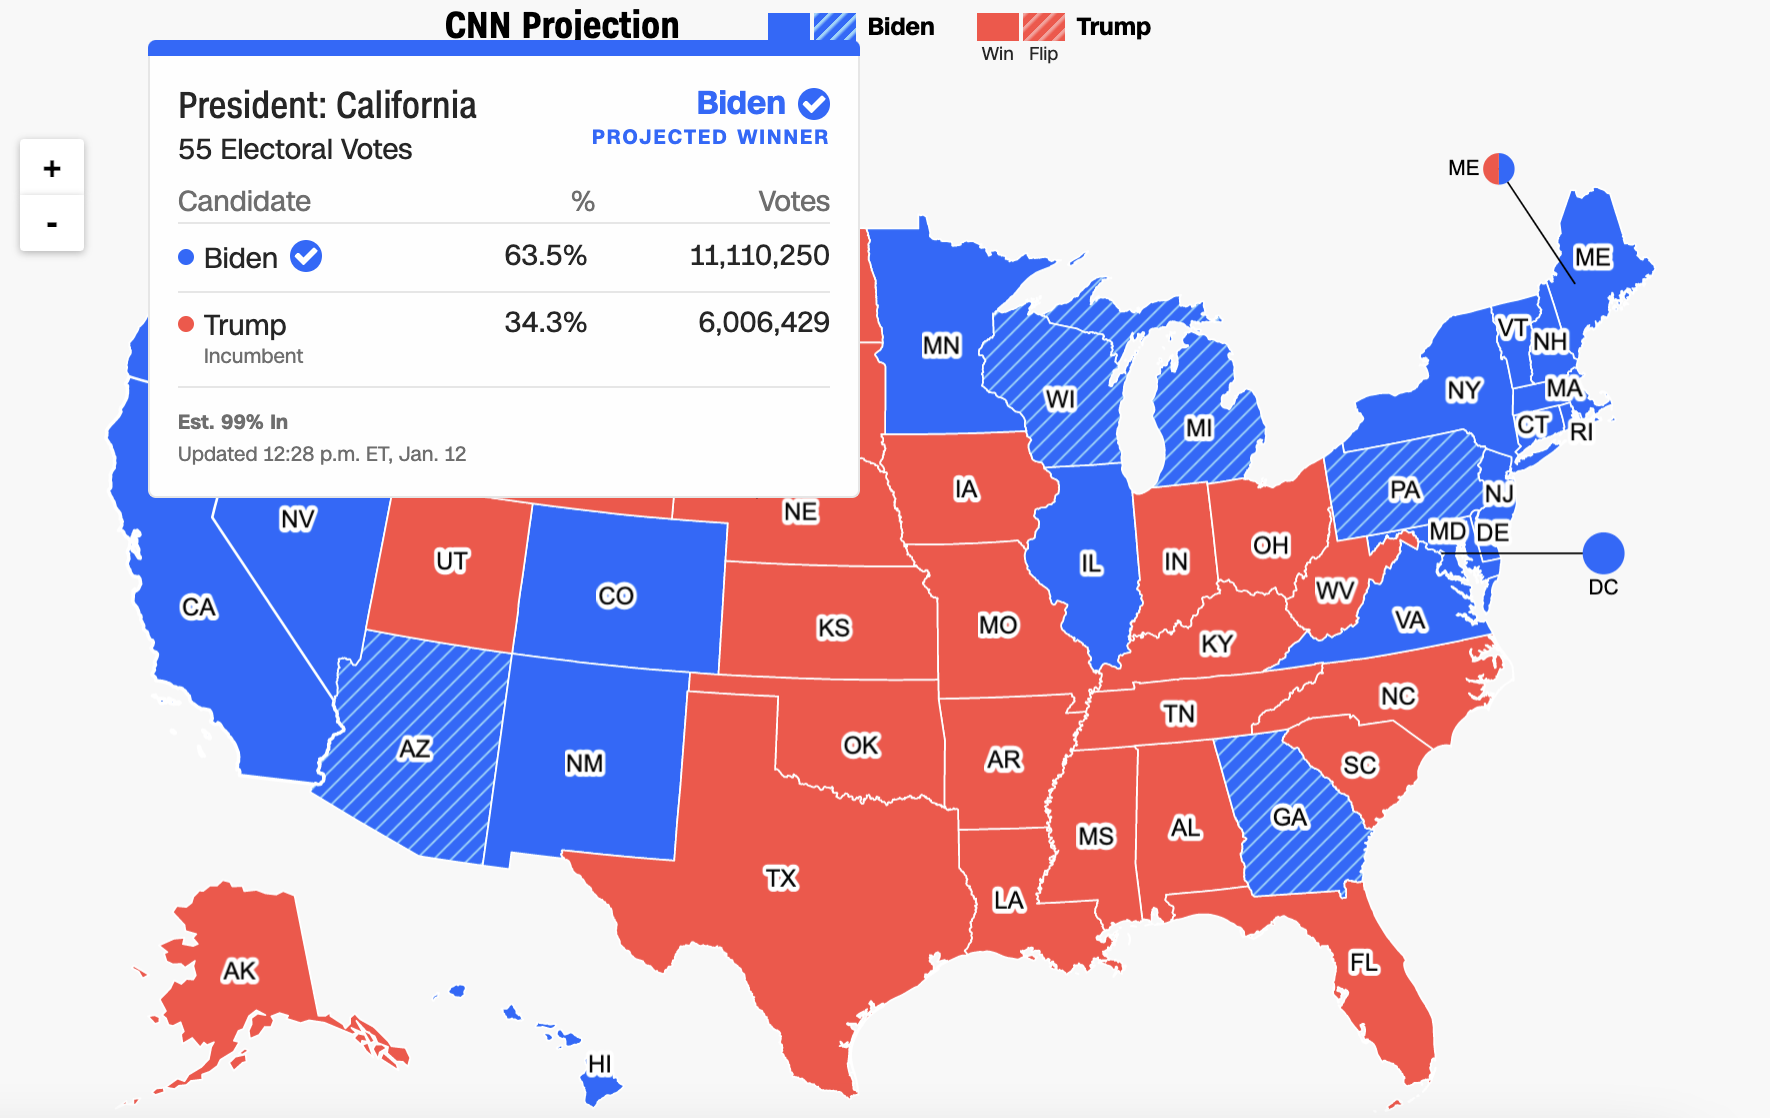